In [40]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData, UVBeam
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle

from numpy.fft import fftshift, fftfreq, fft
from scipy import signal, interpolate

from itertools import combinations_with_replacement

In [101]:
def get_vis_data(files,jd_range):
    
    uvd = UVData()
    if len(files)>1:
        uvd.read(files,axis='freq',time_range=jd_range)
    else:
        uvd.read(files,time_range=jd_range)

    ants = uvd.get_ants()
    pols = uvd.get_pols()
    Nbl = uvd.Nbls
    freqs = (uvd.freq_array)[0]
    lsts = np.unique(uvd.lst_array)*180./(15.*np.pi)
    uvw = (uvd.uvw_array).reshape(-1,Nbl,3)
    bls = np.sqrt(np.sum(uvw[0]**2,axis=1))
    bls = bls[bls!=0.]
  
    autos = np.zeros((3,2,len(lsts),len(freqs)),dtype=np.complex)
    cross = np.zeros((3,2,len(lsts),len(freqs)),dtype=np.complex)

    cross_IDs = []

    i = 0
    j = 0

    for ant1, ant2 in combinations_with_replacement(ants, 2):
        if ant1==ant2:
            autos[i,0] = uvd.get_data([ant1,ant2,'xx'])
            autos[i,1] = uvd.get_data([ant1,ant2,'yy'])
            i+=1
        else:
            cross_IDs.append([ant1,ant2])
            cross[j,0] = uvd.get_data([ant1,ant2,'xx'])
            cross[j,1] = uvd.get_data([ant1,ant2,'yy'])
            j+=1
    return autos, cross, cross_IDs, freqs, lsts, ants, bls, pols

def dB(x):
    return 10.*np.log10(x/np.amax(x))

def colorbar_plotter(fig,ax,im,label):
        
    pos = ax.get_position()
    cbarax = fig.add_axes([pos.x0 + pos.width+0.01, pos.y0, 0.008, pos.height])

    cbar = fig.colorbar(im,cax=cbarax)

    cbar.ax.tick_params(labelsize=16) 
    cbar.ax.set_ylabel(label,fontsize=16)
    
    return cbar

def cross_plotter(spectrum,freqs,lsts,label_str,supertitle):
    
    nu_g, t_g = np.meshgrid(freqs,lsts)
    
    fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(20,20))
    fig.subplots_adjust(wspace=0.25,hspace=0.15)
    fig.suptitle(supertitle,fontsize=18)
    
    axs[0,0].set_title("Absolute value",fontsize=16)
    axs[0,1].set_title("Phase",fontsize=16)
     
    for i in range(3):        
        axim1 = axs[i,0].pcolormesh(nu_g,t_g,abs(spectrum[i]),norm=LogNorm(),cmap='Spectral_r')
        axim2 = axs[i,1].pcolormesh(nu_g,t_g,np.angle(spectrum[i]),vmin=-3.14,vmax=3.14,cmap='hsv')   
    
        
    
        for j in range(2):
            axs[i,j].tick_params(axis='both',direction='in',which='both',labelsize=14)
            if j==0:
                axs[i,j].set_ylabel('%s\n'%(label_str[i])+r'LST$\,[$h$]$',fontsize=16)
                colorbar_plotter(fig,axs[i,j],axim1,r'Arb. units')
            else:
                colorbar_plotter(fig,axs[i,j],axim2,r'[rad]')
            if i==2:
                axs[i,j].set_xlabel(r'$\nu\,[$MHz$]$',fontsize=16)        

def closest_idx(array,value):
    
    idx = np.argmin(abs(array-value))
    if idx.dtype == np.int64:
        return idx
    else:
        return idx[0]
    
def beam_track(beam,lst,freq,RA,DEC):

    beam_interp = beam.interp(freq_array=np.asarray([freq]),new_object=True)
   
    theta = beam.axis2_array
    phi = beam.axis1_array - np.pi
    
    interp_beam_x = interpolate.RectBivariateSpline(theta, phi, (beam_interp.data_array)[0,0,0,0])
    interp_beam_y = interpolate.RectBivariateSpline(theta, phi, (beam_interp.data_array)[0,0,1,0])
    
    track = np.zeros((2,len(lst)))
    for i, t in enumerate(lst):
        Az, Za = Ra_Dec_to_Az_El(RA,DEC,t)
        track[0,i] = interp_beam_x(Za,Az)
        track[1,i] = interp_beam_y(Za,Az)
        
    return track

def Ra_Dec_to_Az_El(RA,Dec,lst):
    
    lat = -30.721527777777847*np.pi/180.
    
    HA = (lst*15.*np.pi/180. - RA)
    
    sin_El = np.sin(Dec)*np.sin(lat)+np.cos(Dec)*np.cos(lat)*np.cos(HA)
    El = np.arcsin(sin_El)
    
    cos_A = (np.sin(Dec) - np.sin(El)*np.sin(lat))/(np.cos(El)*np.cos(lat))
    sin_A = -np.sin(HA)*np.cos(Dec)/np.cos(El)
    Az = np.arctan2(sin_A,cos_A)
  
    return Az, 0.5*np.pi - El


def pierce_point(beam,lst,freq,RA,DEC):

    beam_interp = beam.interp(freq_array=freq,new_object=True)
   
    theta = beam.axis2_array
    phi = beam.axis1_array - np.pi
    
    Az, Za = Ra_Dec_to_Az_El(RA,DEC,lst)
    
    track = np.zeros((2,len(freq)))
    for i, f in enumerate(freqs):
        for j in range(2):
            interp_beam = interpolate.RectBivariateSpline(theta, phi, (beam_interp.data_array)[0,0,j,i])
            track[j,i] = interp_beam(Za,Az)
        
    return track

Text(15.0, 26.0, '2')

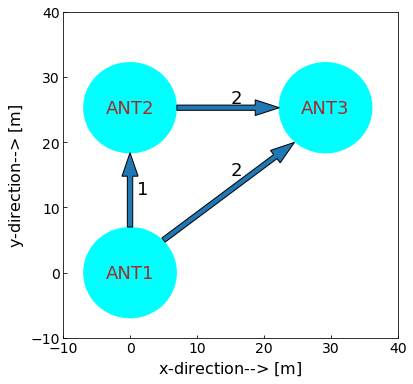

In [75]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(6,6))
ant1 = plt.Circle((0.,0.),7.,facecolor='cyan')
ant2 = plt.Circle((0.,25.288),7.,facecolor='cyan')
ant3 = plt.Circle((29.200,25.288),7.,facecolor='cyan')

axs.add_artist(ant1)
axs.add_artist(ant2)
axs.add_artist(ant3)

axs.set_xlim(-10.,40.)
axs.set_ylim(-10.,40.)

plt.text(0.,0., 'ANT1',
         horizontalalignment='center',
         verticalalignment='center',
         multialignment='center',fontsize=18,color='brown')

plt.text(0.,25.288, 'ANT2',
         horizontalalignment='center',
         verticalalignment='center',
         multialignment='center',fontsize=18,color='brown')

plt.text(29.2,25.288, 'ANT3',
         horizontalalignment='center',
         verticalalignment='center',
         multialignment='center',fontsize=18,color='brown')

axs.tick_params(axis='both',direction='in',which='both',labelsize=14)

axs.set_xlabel(r'x-direction--> $[$m$]$',fontsize=16)
axs.set_ylabel(r'y-direction--> $[$m$]$',fontsize=16)

axs.arrow(x=0., y=7., dx=0, dy=25.288-17.5, width=.8) 
axs.arrow(x=5., y=5., dx=29.2-12.5, dy=25.288-12.5, width=.8) 
axs.arrow(x=7., y=25.288, dx=29.2-17.5, dy=0, width=.8) 

axs.annotate('1', xy = (1.,12.),fontsize=18)
axs.annotate('2', xy = (14.,14.),fontsize=18)
axs.annotate('3', xy = (15.,27.),fontsize=18)

In [3]:
uvb = UVBeam()
uvb.read_beamfits('NF_HERA_Dipole_power_beam.fits')
uvb.freq_interp_kind = 'cubic'
uvb.interpolation_function = 'az_za_simple'

RA = 150.*np.pi/180.
DEC = -30.7224*np.pi/180.

In [4]:
JDstart = 2458116.24485307
JDend = JDstart + (22./24.)

files_nocc_1src = np.sort(glob('/data7/pyuvsim_results/Cross-coupling-beam-sims/results/HERA_no-cc-3ant_1src_spw1_820ch-24h.uvh5'))
files_nocc_2src = np.sort(glob('/data7/pyuvsim_results/Cross-coupling-beam-sims/results/HERA_no-cc-3ant_2src_spw1_820ch-24h.uvh5'))

files_cc_1src = np.sort(glob('/data7/pyuvsim_results/Cross-coupling-beam-sims/results/HERA_cc-3ant_1src_spw*_410ch-24hr.uvh5'))
files_cc_2src = np.sort(glob('/data7/pyuvsim_results/Cross-coupling-beam-sims/results/HERA_cc-3ant_2src_spw*_410ch-24hr.uvh5'))

In [5]:
autos_nocc_1src, cross_nocc_1src, cross_IDs, freqs, lsts, ants, bls, pols = get_vis_data(files_nocc_1src,[JDstart,JDend])
autos_nocc_2src, cross_nocc_2src, _, _, _, _, _, _ = get_vis_data(files_nocc_2src,[JDstart,JDend])
autos_cc_1src, cross_cc_1src, _, _, _, _, _, _ = get_vis_data(files_cc_1src,[JDstart,JDend])
autos_cc_2src, cross_cc_2src, _, _, _, _, _, _ = get_vis_data(files_cc_2src,[JDstart,JDend])

antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.


In [6]:
src1_idx = np.where(autos_nocc_1src[0,0,:,0]!=0.)
src2_idx = np.where(autos_nocc_2src[0,0,:,0]!=0.)

lst_1src = lsts[src1_idx[0]]
lst_2src = lsts[src2_idx[0]]

In [7]:
nu1_g, lst1_g = np.meshgrid(freqs/1.e6,lst_1src)
nu2_g, lst2_g = np.meshgrid(freqs/1.e6,lst_2src)

Text(0.5, 1.0, 'N-pol')

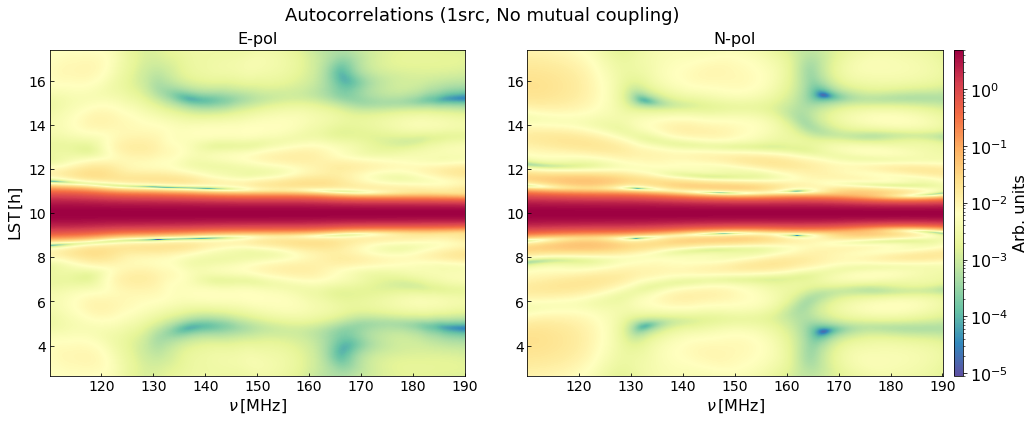

In [8]:
fig1, axs = plt.subplots(nrows=1,ncols=2,figsize=(16,6))
fig1.subplots_adjust(wspace=0.15)
fig1.suptitle(r'Autocorrelations (1src, No mutual coupling)',fontsize=18)

for i in range(2):        
    axim = axs[i].pcolormesh(nu1_g,lst1_g,abs(autos_nocc_1src[0,i,src1_idx[0]]),norm=LogNorm(),cmap='Spectral_r')    
    axs[i].tick_params(axis='both',direction='in',which='both',labelsize=14)
    axs[i].set_xlabel(r'$\nu\,[$MHz$]$',fontsize=16)     
    
    if i==0:
        axs[i].set_ylabel(r'LST$\,[$h$]$',fontsize=16)
    else:
        colorbar_plotter(fig1,axs[i],axim,r'Arb. units')
         
axs[0].set_title(r'E-pol',fontsize=16)
axs[1].set_title(r'N-pol',fontsize=16)

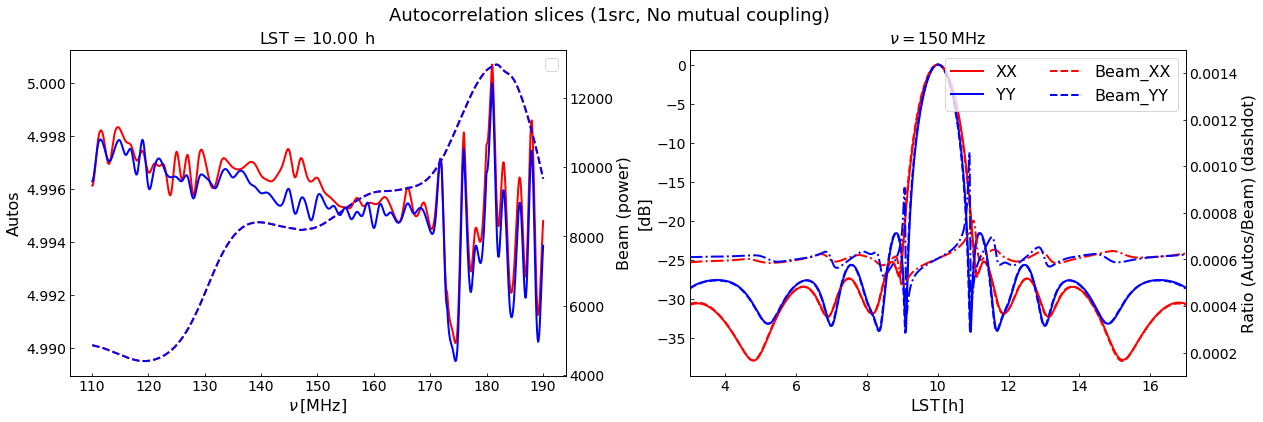

In [98]:
freq_idx = closest_idx(freqs,150.e6) #set frequency value here
lst_idx  = closest_idx(lsts,10.) #set LST value here

track = beam_track(uvb,lst_1src,freqs[freq_idx],RA,DEC)
spectra = pierce_point(uvb,lsts[lst_idx],freqs,RA,DEC)

fig2, axs = plt.subplots(nrows=1,ncols=2,figsize=(20,6))
fig2.subplots_adjust(wspace=0.25)
fig2.suptitle(r'Autocorrelation slices (1src, No mutual coupling)',fontsize=18)

axs[0].plot(freqs/1.e6,abs(autos_nocc_1src[1,0,lst_idx,:]),c='r',ls='-',lw=2)
axs[0].plot(freqs/1.e6,abs(autos_nocc_1src[1,1,lst_idx,:]),c='b',ls='-',lw=2)
#axs[0].plot(freqs,5.e-4*,c='r',ls='--',lw=2)
#axs[0].plot(freqs,,c='b',ls='--',lw=2)

axs0 = axs[0].twinx()
axs0.plot(freqs/1.e6,spectra[1],c='r',ls='--',lw=2)
axs0.plot(freqs/1.e6,spectra[0],c='b',ls='--',lw=2)
axs0.tick_params(axis='both',direction='in',which='both',labelsize=14)
axs0.set_ylabel(r'Beam (power)',fontsize=16)

handles, labels = axs0.get_legend_handles_labels()
axs0.legend(handles,labels,fontsize=16,ncol=1,loc='upper right')

axs[1].plot(lst_1src,dB(abs(autos_nocc_1src[0,0,src1_idx[0],freq_idx])),c='r',ls='-',lw=2,label=r'XX')
axs[1].plot(lst_1src,dB(abs(autos_nocc_1src[0,1,src1_idx[0],freq_idx])),c='b',ls='-',lw=2,label=r'YY')
axs[1].plot(lst_1src,dB(track[1]),c='r',ls='--',lw=2,label=r'Beam_XX')
axs[1].plot(lst_1src,dB(track[0]),c='b',ls='--',lw=2,label=r'Beam_YY')
axs[1].set_xlim(3,17)

axs1 = axs[1].twinx()
axs1.plot(lst_1src,(autos_nocc_1src[0,0,src1_idx[0],freq_idx]).real/track[1],c='r',ls='-.',lw=2)
axs1.plot(lst_1src,(autos_nocc_1src[0,1,src1_idx[0],freq_idx]).real/track[0],c='b',ls='-.',lw=2)

axs1.tick_params(axis='both',direction='in',which='both',labelsize=14)
axs1.set_ylabel(r'Ratio (Autos/Beam) (dashdot)',fontsize=16)
axs1.set_ylim(0.0001,0.0015)
axs1.set_xlim(3,17)

axs[0].set_xlabel(r'$\nu\,[$MHz$]$',fontsize=16)
axs[1].set_xlabel(r'LST$\,[$h$]$',fontsize=16)

axs[0].set_title(r'LST = %.2f $\,$h'%(lsts[lst_idx]),fontsize=16)
axs[1].set_title(r'$\nu = 150\,$MHz',fontsize=16)

axs[0].set_ylabel(r'Autos',fontsize=16)
axs[1].set_ylabel(r'[dB]',fontsize=16)


handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles,labels,fontsize=16,ncol=2,loc='upper right')


for i in range(2):        
    
    axs[i].tick_params(axis='both',direction='in',which='both',labelsize=14)

    
    

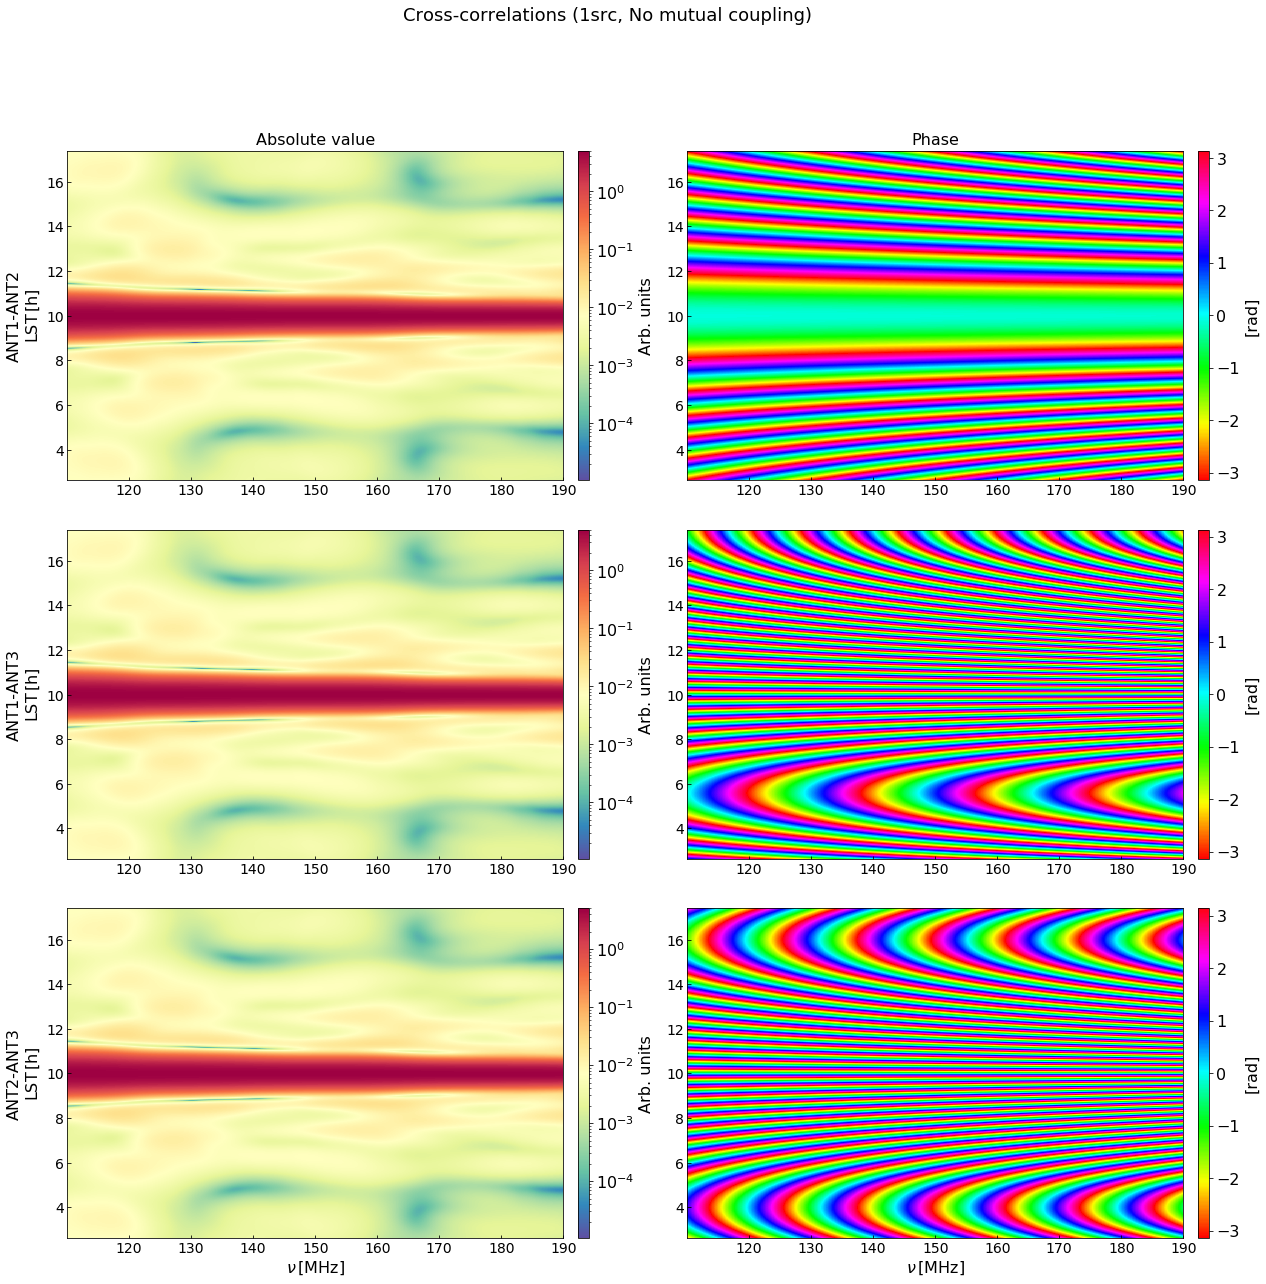

In [102]:
cross_str = ['ANT1-ANT2','ANT1-ANT3','ANT2-ANT3']
cross_plotter(cross_nocc_1src[:,0,src1_idx[0]],freqs/1.e6,lst_1src,cross_str,'Cross-correlations (1src, No mutual coupling)')

Text(0.5, 1.0, 'N-pol')

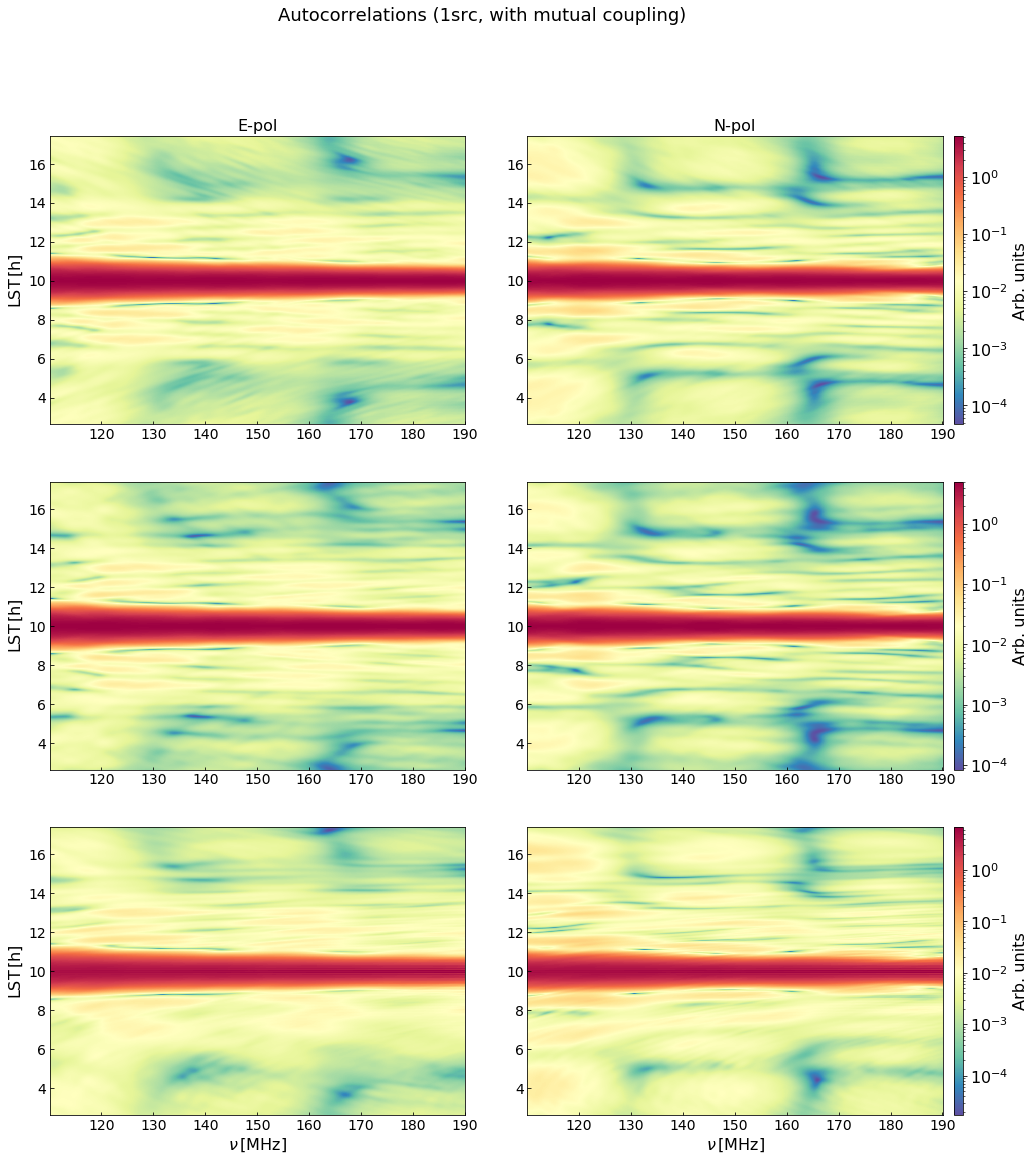

In [100]:
fig3, axs = plt.subplots(nrows=3,ncols=2,figsize=(16,18))
fig3.subplots_adjust(wspace=0.15)
fig3.suptitle(r'Autocorrelations (1src, with mutual coupling)',fontsize=18)

for i in range(3):
    for j in range(2):        
        axim = axs[i,j].pcolormesh(nu1_g,lst1_g,abs(autos_cc_1src[i,j,src1_idx[0]]),norm=LogNorm(),cmap='Spectral_r')    
        axs[i,j].tick_params(axis='both',direction='in',which='both',labelsize=14)
        if i==2:
            axs[i,j].set_xlabel(r'$\nu\,[$MHz$]$',fontsize=16)     
    
        if j==0:
            axs[i,j].set_ylabel(r'LST$\,[$h$]$',fontsize=16)
        else:
            colorbar_plotter(fig3,axs[i,j],axim,r'Arb. units')

axs[0,0].set_title(r'E-pol',fontsize=16)
axs[0,1].set_title(r'N-pol',fontsize=16)

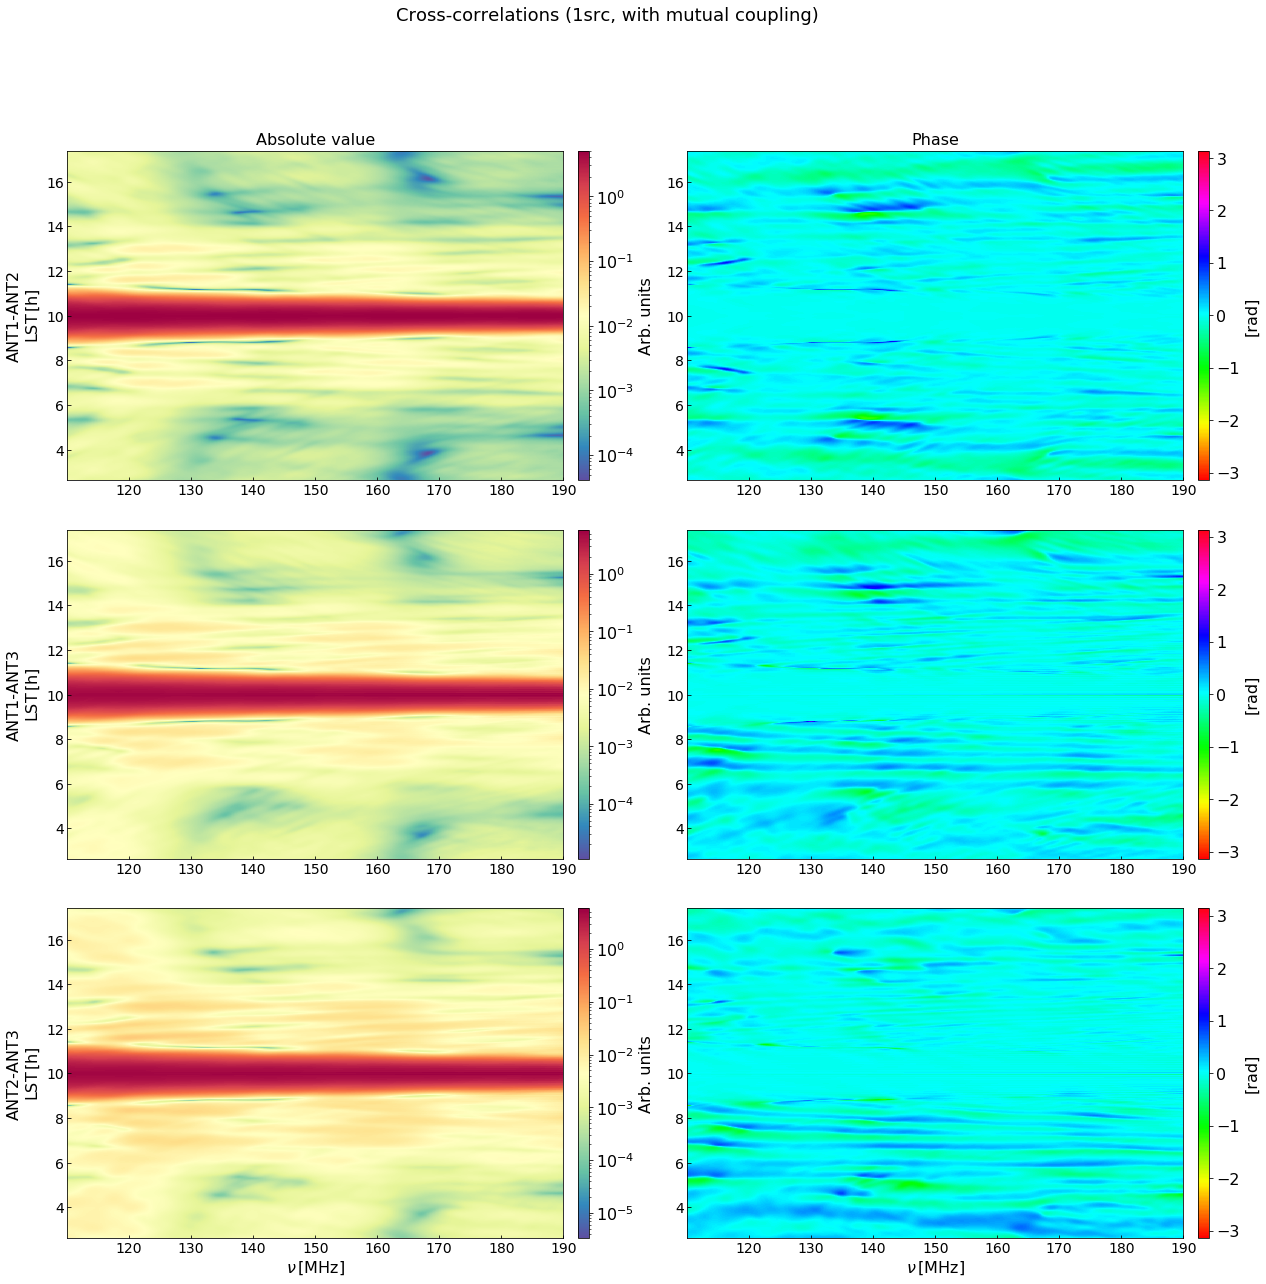

In [103]:
cross_plotter(cross_cc_1src[:,0,src1_idx[0]],freqs/1.e6,lst_1src,cross_str,'Cross-correlations (1src, with mutual coupling)')